In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm
import scipy
from scipy.stats import norm
from scipy.stats.mstats import gmean

from statsmodels.nonparametric.smoothers_lowess import lowess

from numpy.lib.stride_tricks import sliding_window_view

# Load data 

In [2]:
df = pd.read_parquet('/Users/julianeoliveira/Downloads/aesop_2025_09_12_mun.parquet')

#df = pd.read_parquet('/Users/julianeoliveira/Downloads/202322_202522_ears_evi_mmaing.parquet')
#df = pd.read_parquet('/home/juliane.oliveira/workspace/Data/aesop_2025_07_17_mun.parquet')

# Functions

In [3]:
# --- helper: smooth MAP curve with LOWESS ---
def smooth_lowess(pr):
    r = np.arange(1, len(pr)+1)
    smoothed = lowess(pr, r, frac=0.3, return_sorted=False)
    return smoothed

# Applying the method to data

In [4]:
lst = ['co_ibge', 'epiyear', 'epiweek','year_week', 'atend_totais', 'atend_ivas']

set_muni = df[df.co_ibge == 110001][lst]



In [5]:
def mem_epidemic_period(set_muni, delta=0.02):
    """
    Compute epidemic period (step 1 of MEM) for each season/year.

    Parameters
    ----------
    set_muni : DataFrame
        Must contain columns ['epiyear', 'atend_ivas'].
    delta : float, optional
        Threshold for slope increment (default=0.02).

    Returns
    -------
    summary : DataFrame
        Columns: ['epiyear', 'r_j_estr', 'k_start', 'k_end']
    details : dict
        Keys = epiyear, values = dict with:
            - r_j_estr : estimated epidemic duration (weeks)
            - k_start  : start week (1-indexed)
            - k_end    : end week (inclusive, 1-indexed)
            - p_j_r    : MAP percentages
            - sm_p_j_r : smoothed MAP curve
            - t_j_r    : cumulative totals by window length
    """
    
    results = {}
    summary_records = []

    for year in sorted(set_muni.epiyear.unique()):
        s1 = set_muni[set_muni.epiyear == year].reset_index(drop=True)

        t = np.asarray(s1.atend_ivas)
        S = len(t)
        tS = np.sum(t)

        # --- compute t_j_r (max accumulated per window length) ---
        t_j_r = np.array([
            sliding_window_view(t, r).sum(axis=1).max()
            for r in range(1, S + 1)
        ])

        # --- MAP curve ---
        p_j_r = t_j_r / tS
        sm_p_j_r = smooth_lowess(p_j_r)

        # --- increments Δr ---
        delta_j_r = np.diff(sm_p_j_r)

        # --- determine optimal duration r_j_estr ---
        indices = np.where(delta_j_r < delta)[0]
        r_j_estr = int(indices.min()) if len(indices) > 0 else S

        # --- find k_estr (start index of epidemic window) ---
        window_r = sliding_window_view(t, r_j_estr)
        window_sums = window_r.sum(axis=1)
        k_estr = window_sums.argmax()

        k_start = k_estr + 1          # 1-indexed
        k_end   = k_estr + r_j_estr   # inclusive

        # --- save results ---
        results[year] = {
            'r_j_estr': r_j_estr,
            'k_start': k_start,
            'k_end': k_end,
            'p_j_r': p_j_r,
            'sm_p_j_r': sm_p_j_r,
            't_j_r': t_j_r
        }

        summary_records.append({
            'epiyear': year,
            'r_j_estr': r_j_estr,
            'k_start': k_start,
            'k_end': k_end
        })

    summary = pd.DataFrame(summary_records)

    return summary, results


In [6]:
summary, details = mem_epidemic_period(set_muni, delta=0.02)

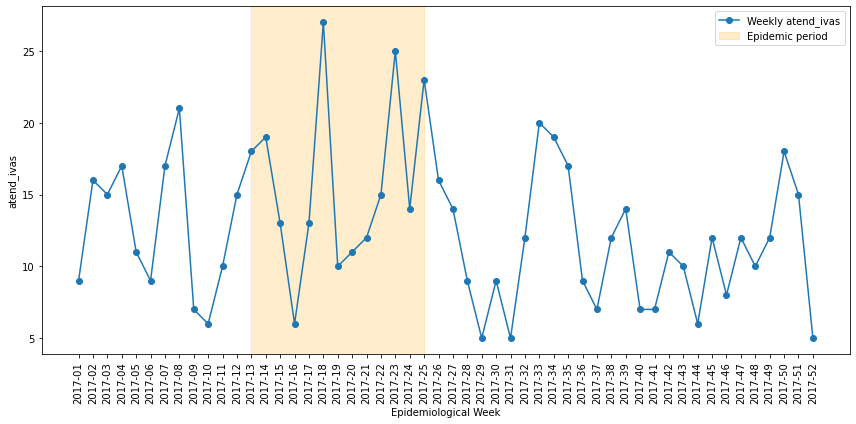

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

year = 2017

season = set_muni[set_muni.epiyear == year].reset_index()

k_s = summary[summary.epiyear == year].k_start.max()

k_e = summary[summary.epiyear == year].k_end.max()
        
# plot weekly values
ax.plot(season["year_week"], season['atend_ivas'], marker="o", label="Weekly atend_ivas")
        
# highlight epidemic window
ax.axvspan(season.loc[k_s-1, "year_week"], season.loc[k_e-1, "year_week"], 
                   color="orange", alpha=0.2, label="Epidemic period")
        
        
# labels
plt.xticks(rotation=90)
ax.set_xlabel("Epidemiological Week")
ax.set_ylabel("atend_ivas")
ax.legend()
plt.tight_layout()
plt.show()

#  Baseline and Epidemic threshold

In [15]:
def baseline_thresholds(dta, lst_sea, value_col="atend_ivas"):
    """
    Compute baselines and epidemic thresholds from seasonal surveillance data.
    
    Parameters
    ----------
    dta : pd.DataFrame
        Full dataset containing at least columns: ["epiyear", "epiweek", value_col].
    lst_sea : list
        List of epidemic years to include in the calculation.
    value_col : str
        Column name with weekly counts (default = 'atend_ivas').
    
    Returns
    -------
        - baseline
        - post_baseline
        - epidemic_threshold
        - post_threshold
        - df_thresholds_intensity (DataFrame with 50%, 90%, 95% thresholds)
    """

    # storage lists
    pre_values, post_values, epi_values = [], [], []
    pre_top, post_top, epi_top = [], [], []

    # number of top values per season
    n = round(30 / len(lst_sea))

    for year in lst_sea:
        season = dta[dta.epiyear == year].reset_index(drop=True)

        k_s = int(summary.loc[summary.epiyear == year, "k_start"].iloc[0])
        k_e = int(summary.loc[summary.epiyear == year, "k_end"].iloc[0])

        # split values
        pre = season.loc[season.epiweek <= k_s, value_col].values
        post = season.loc[season.epiweek > k_e, value_col].values
        epi = season.loc[(season.epiweek > k_s) & (season.epiweek <= k_e), value_col].values

        # extend pooled samples
        pre_values.extend(pre)
        post_values.extend(post)
        epi_values.extend(epi)

        # extend top-n values per season
        pre_top.extend(sorted(pre, reverse=True)[:n])
        post_top.extend(sorted(post, reverse=True)[:n])
        epi_top.extend(sorted(epi, reverse=True)[:n])

    # convert to arrays
    pre_values, post_values, epi_values = map(np.array, [pre_values, post_values, epi_values])
    pre_top, post_top, epi_top = map(np.array, [pre_top, post_top, epi_top])

    # ---- Baselines ----
    baseline = np.mean(pre_values)
    post_baseline = np.mean(post_values)

    # ---- Epidemic threshold ----
    mean_pre, std_pre = np.mean(pre_top), np.std(pre_top, ddof=1)
    z = norm.ppf(0.95)  # one-sided 95%
    epidemic_threshold = mean_pre + z * std_pre

    # ---- Post-epidemic threshold ----
    mean_post, std_post = np.mean(post_top), np.std(post_top, ddof=1)
    post_threshold = mean_post + z * std_post

    # ---- Intensity thresholds ----
    log_vals = np.log(epi_top)
    mean_log, sd_log = np.mean(log_vals), np.std(log_vals, ddof=1)

    thresholds_intensity = {
        f"{int(p*100)}%": np.exp(mean_log + norm.ppf(p) * sd_log)
        for p in [0.50, 0.90, 0.95]
    }

    df_thresholds_intensity = pd.DataFrame(
        list(thresholds_intensity.items()), columns=["percentile", "value"]
    )

    return  baseline,  epidemic_threshold, df_thresholds_intensity #post_baseline, post_threshold,
    


In [16]:
lst_sea = [2017, 2018, 2019, 2022, 2023, 2024] #2020, 2021

In [10]:
baseline, epidemic_threshold, df_thresholds_intensity = baseline_thresholds(set_muni, lst_sea, value_col="atend_ivas")

In [11]:
baseline

18.83941605839416

In [12]:
epidemic_threshold

64.13925275809707

In [13]:
df_thresholds_intensity

,percentile,value
0,50%,39.397220
1,90%,84.098789
2,95%,104.267405


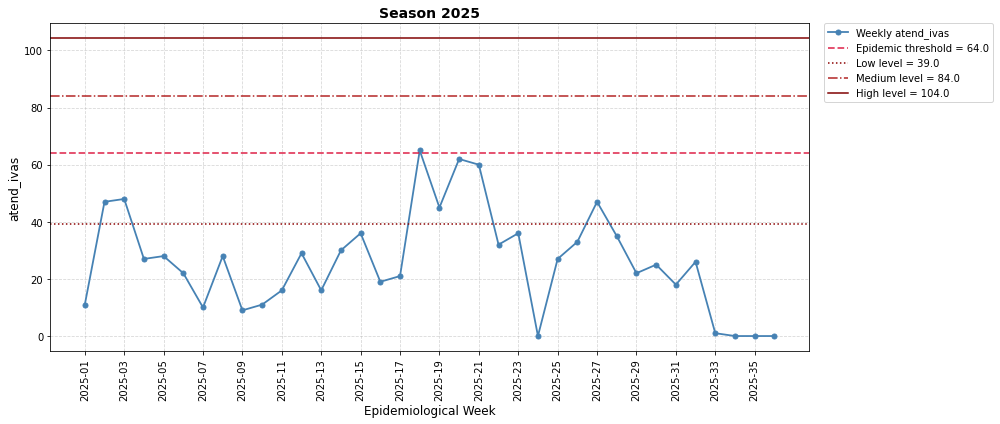

In [14]:
fig, ax = plt.subplots(figsize=(14,6))

year = 2025

# subset the season data
season = set_muni[set_muni.epiyear == year].reset_index(drop=True)

# get start and end from summary
k_s = int(summary.loc[summary.epiyear == year, "k_start"].iloc[0])
k_e = int(summary.loc[summary.epiyear == year, "k_end"].iloc[0])

# plot weekly values
ax.plot(season["year_week"], season['atend_ivas'], 
        marker="o", markersize=5, linewidth=1.8, color="steelblue", 
        label="Weekly atend_ivas")

# thresholds
ax.axhline(epidemic_threshold, color="crimson", alpha=0.8, linestyle="--", linewidth=1.8,
           label=f"Epidemic threshold = {round(epidemic_threshold,0)}")

ax.axhline(df_thresholds_intensity.value.iloc[0], color="darkred", linestyle=":", linewidth=1.5,
           label=f"Low level = {round(df_thresholds_intensity.value.iloc[0],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[1], color="firebrick", linestyle="-.", linewidth=1.5,
           label=f"Medium level = {round(df_thresholds_intensity.value.iloc[1],0)}")
ax.axhline(df_thresholds_intensity.value.iloc[2], color="maroon", linestyle="-", linewidth=1.5,
           label=f"High level = {round(df_thresholds_intensity.value.iloc[2],0)}")

# labels & formatting
ax.set_xlabel("Epidemiological Week", fontsize=12)
ax.set_ylabel("atend_ivas", fontsize=12)
ax.set_title(f"Season {year}", fontsize=14, fontweight="bold")

# x-axis ticks (reduce clutter)
ax.set_xticks(season["year_week"][::2])  # every 2 weeks
ax.set_xticklabels(season["year_week"][::2], rotation=90)

# grid
ax.grid(True, linestyle="--", alpha=0.5)

# legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()
